<a href="https://colab.research.google.com/github/NoorFatimaMemon/DeepLearning/blob/main/26_Intro_to_Autoencoders/26_Intro_to_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Autoencoders**

An **autoencoder** is a special type of nn used to compress data and then reconstruct it. (or that is trained to copy its input to its output)

It's made of two parts:

- **Encoder**: Compresses the input (e.g., image).
- **Decoder**: Reconstructs the input from the compressed version.

For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

We will introduce autoencoders with two examples: the basics & image denoising

# **Importing libraries**

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# **Loading CIFAR-10 Dataset & Preprocess Images**

Each image in this dataset is 32x32 pixels.

In [13]:
(x_train, _), (x_test, _) = cifar10.load_data()   #_ means ignore labels since autoencoders are unsupervised

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

print("Training shape:", x_train.shape)  # (50000, 32, 32, 3)
print("Test shape:", x_test.shape)      # (10000, 32, 32, 3)

Training shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)


# **Basic Autoencoder**

Define an autoencoder with 2 Dense layers:

- `encoder`, which compresses the images into a 64 dimensional latent vector
- `decoder`, that reconstructs the original image from the latent space.

In [14]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([layers.Input(shape=(32, 32, 3)),
                                            layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),  # (16,16,32)
                                            layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),  # (8,8,64)
                                            layers.Flatten(), layers.Dense(latent_dim),])

        self.decoder = tf.keras.Sequential([layers.Dense(8*8*64, activation='relu'), layers.Reshape((8, 8, 64)),
                                            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),  # (16,16,64)
                                            layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),  # (32,32,32)
                                            layers.Conv2D(3, 3, activation='sigmoid', padding='same')  # (32,32,3)
                                            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# **Compile and Train the Autoencoder**

In [15]:
latent_dim = 64  # Try 64, 128, or 256 depending on how much compression you want
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
autoencoder.fit(x_train, x_train, epochs=50, shuffle=True, validation_data=(x_test, x_test), callbacks=[early_stop])

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0220 - val_loss: 0.0089
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 9/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 10/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 11/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 12/50
1563/1563 ━━━

# **Visualize Reconstructed Images**

In [16]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

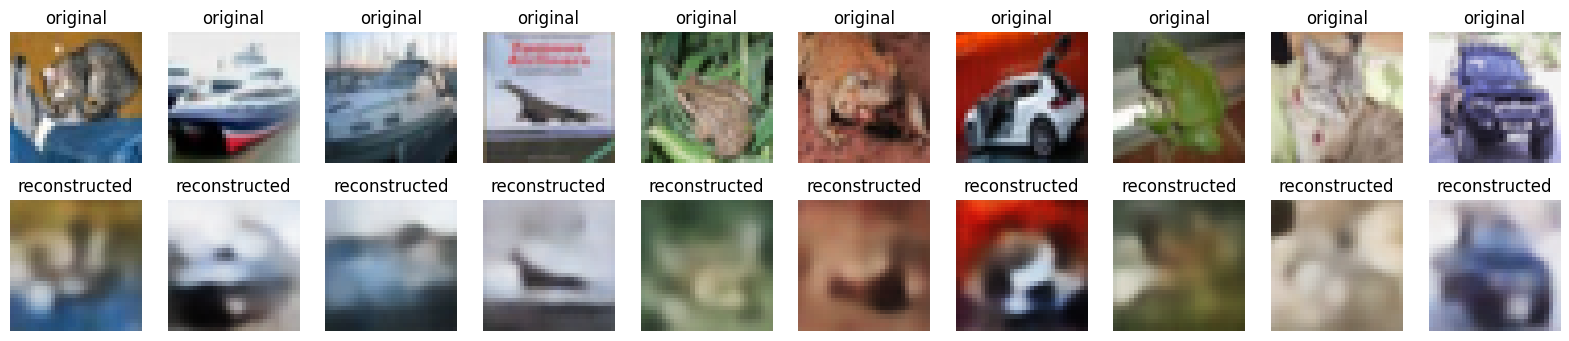

In [17]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    ax.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    ax.axis('off')
plt.show()

# **Denoising Autoencoder**

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the cifar10 dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [18]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print("Training shape:", x_train.shape)
print("Test shape:", x_test.shape)

Training shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)


# **Add Noise**

In [19]:
noise_factor = 0.05
# Adds random noise to each pixel.
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

In [20]:
# Clips values to ensure all pixels are between 0 and 1
x_train_noisy = tf.clip_by_value(x_train_noisy, 0., 1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, 0., 1.)

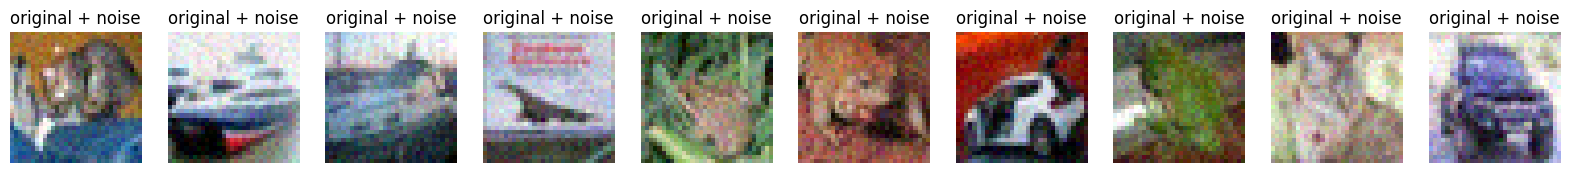

In [21]:
# Plot Noisy Images
plt.figure(figsize=(20, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.title("original + noise")
    plt.imshow(x_test_noisy[i])   # tf.squeeze removes the channel dimension so images can be plotted.
    ax.axis('off')
plt.show()

# **Defining the Convolutional Autoencoder**

In [22]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([layers.Input(shape=(32, 32, 3)),
                                            layers.Conv2D(32, 3, activation='relu', padding='same', strides=2),
                                            layers.Conv2D(64, 3, activation='relu', padding='same', strides=2),])

        self.decoder = tf.keras.Sequential([layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
                                            layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
                                            layers.Conv2D(3, 3, activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [23]:
import tensorflow.image as tfi
def ssim_loss(y_true, y_pred):
    return 1 - tfi.ssim(y_true, y_pred, max_val=1.0)

In [24]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=ssim_loss)
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
autoencoder.fit(x_train_noisy, x_train, epochs=50, shuffle=True, validation_data=(x_test_noisy, x_test), callbacks=[early_stop])

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.1879 - val_loss: 0.0688
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0653 - val_loss: 0.0619
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0594 - val_loss: 0.0566
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0570 - val_loss: 0.0555
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0555 - val_loss: 0.0538
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0544 - val_loss: 0.0542
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0532 - val_loss: 0.0523
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0526 - val_loss: 0.0535
Epoch 9/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0521 - val_loss: 0.0519
Epoch 10/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0514 - val_loss: 0.0503
Epoch 11/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0508 - val_loss: 0.0509
Epoch 12/50
1563/1563 ━━

# **Plot Noisy and Denoised Images**

In [25]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

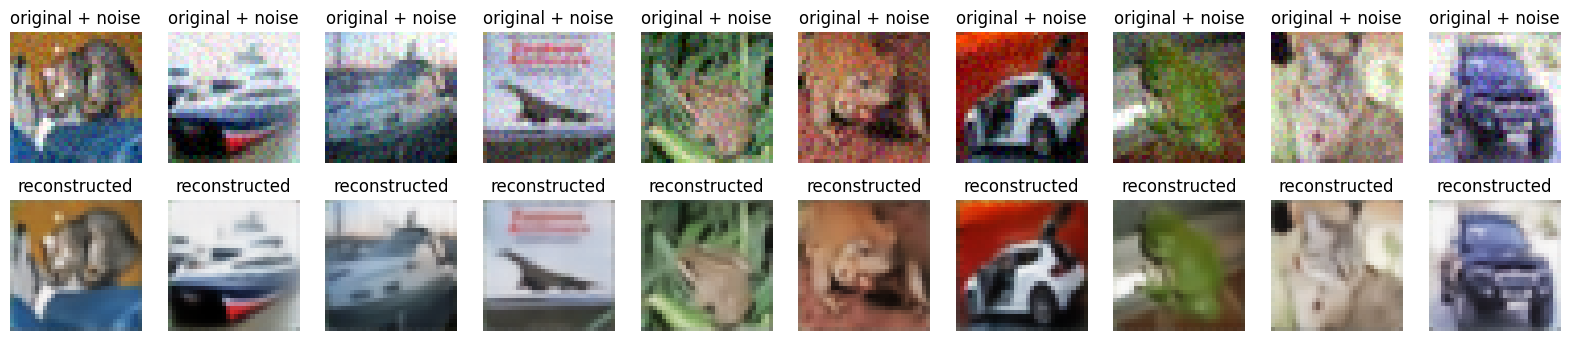

In [26]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    ax.axis('off')

    ax = plt.subplot(2, 10, i + 11)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    ax.axis('off')
plt.show()